In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# this will calculate the angular 
# and energy resolution histograms
%run ../../core/resolution.py
%run ../../core/prepare_histograms.py
## -> only run this if you need to update the histograms

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Import

In [3]:
import pickle
from os.path import join
import numpy as np
import seaborn as sns
from settings import *

from resolution import comb, g_norm, double_erf


# Load resolution baseline

In [4]:
with open(join(LOCALPATH, "energy_smearing_MH_up.pckl"), "rb") as f:
    eres_up_mh = pickle.load(f)


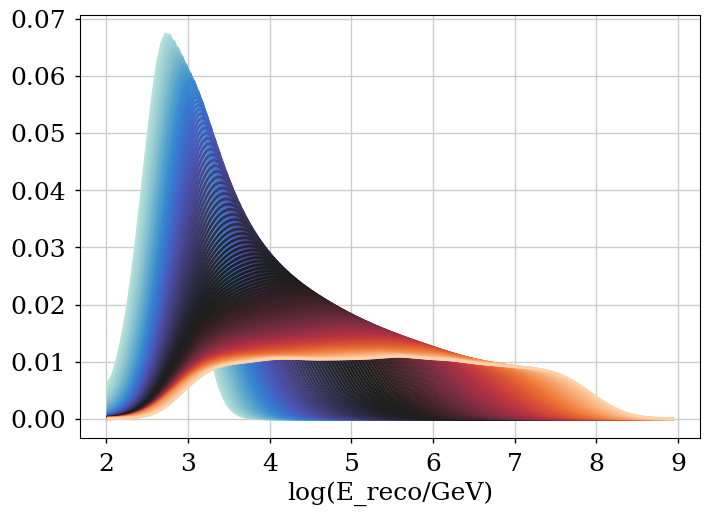

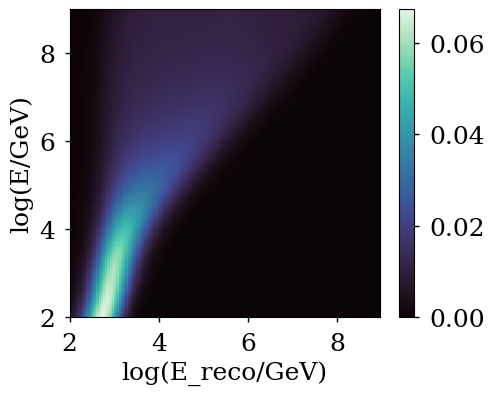

In [5]:
sns.set_palette("icefire", n_colors=eres_up_mh.shape[1] + 1)
_ = plt.plot(eres_up_mh.bin_mids[1], eres_up_mh.histo.T)
plt.xlabel(eres_up_mh.axis_names[1])
eres_up_mh.T().plot()
plt.colorbar(plt.gca().get_children()[0])

# Testing
from resolution import fit_eres_params, smooth_eres_fit_params, artificial_eres

# we need the transposed matrix for further calculations
eres_up_T = eres_up_mh.T()
# Parameterize the smearing matrix
fit_params = fit_eres_params(eres_up_T)
test_2d = artificial_eres(fit_params, *eres_up_T.bins)

plt.figure()
_ = plt.plot(test_2d.bin_mids[0], test_2d.histo)

plt.figure()
diff = eres_up_T - test_2d
_ = plt.plot(diff.bin_mids[0], diff.histo)
plt.xlabel(diff.axis_names[0])


# 2D
test_2d.T().plot()
plt.colorbar(plt.gca().get_children()[0])
eres_up_mh.plot()
plt.colorbar(plt.gca().get_children()[0])


diff.T().plot(cmap="icefire")
plt.colorbar(plt.gca().get_children()[0])


# Parametrizations

In [6]:
fit_params = np.load(join(LOCALPATH, "Eres_fits.npy"))

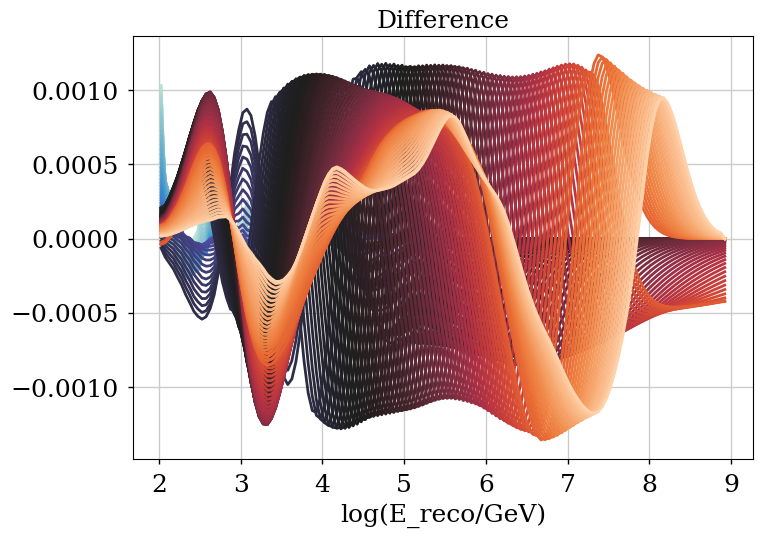

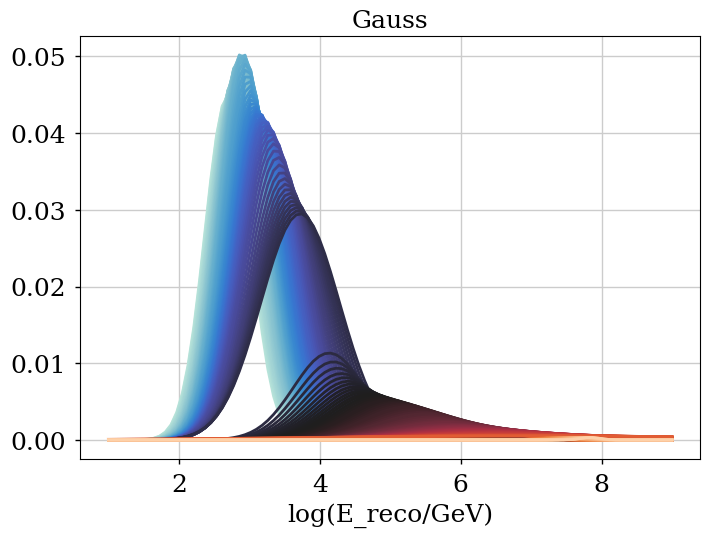

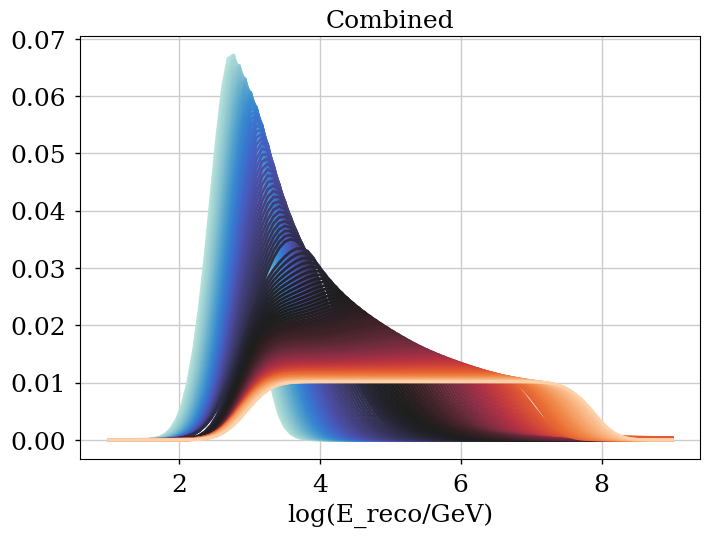

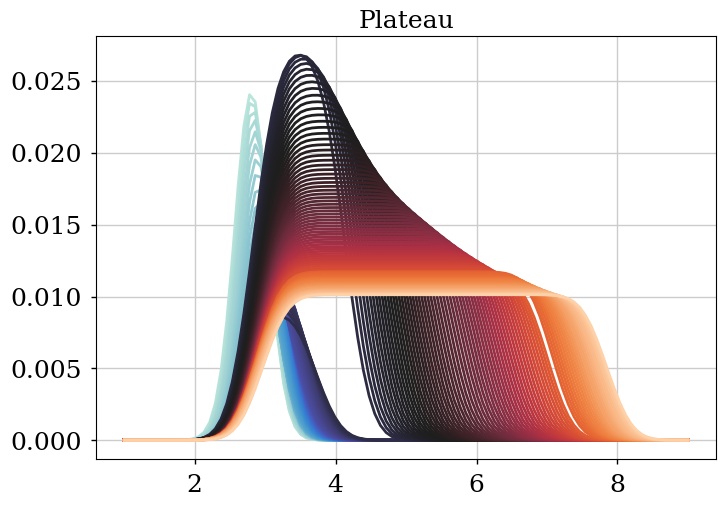

In [7]:
xvals = np.linspace(1, 9, num=100)
for ii, et in enumerate(eres_up_mh.bin_mids[0]):
    cur_params = list(fit_params[ii])
    plt.figure(-1)
    plt.title("Difference")
    p = plt.plot(
        eres_up_mh.bin_mids[1],
        eres_up_mh.histo[ii] - comb(eres_up_mh.bin_mids[1], *cur_params),
    )
    plt.xlabel(eres_up_mh.axis_names[1])

    plt.figure(1)
    plt.title("Gauss")
    plt.plot(
        xvals,
        g_norm(xvals, *cur_params[-3:]),
        color=p[0].get_color(),
        lw=2,
    )
    plt.xlabel(eres_up_mh.axis_names[1])
    
    plt.figure(2)
    plt.title("Combined")
    plt.plot(
        xvals,
        comb(xvals, *cur_params),
        color=p[0].get_color(),
        lw=2,
        zorder=10,
    )
    plt.xlabel(eres_up_mh.axis_names[1])
    
    plt.figure(3)
    plt.title("Plateau")
    plt.plot(
        xvals,
        double_erf(xvals, *[cur_params[i] for i in (0, 2, 1)]),
        color=p[0].get_color(),
        lw=2,
    )


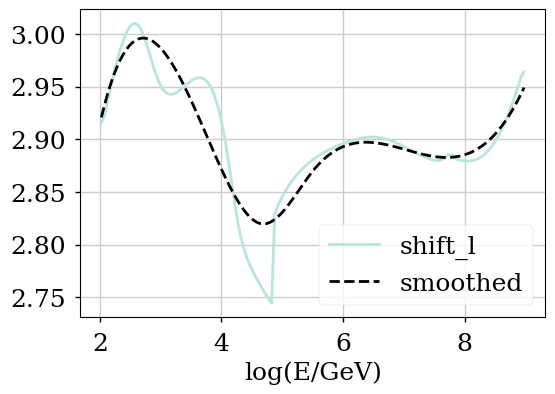

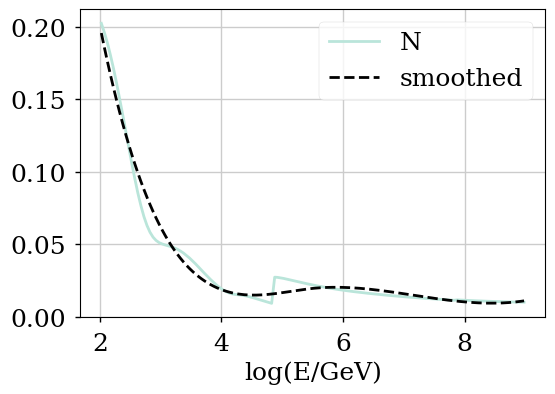

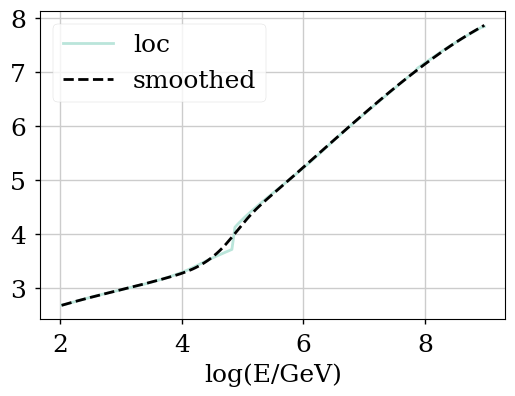

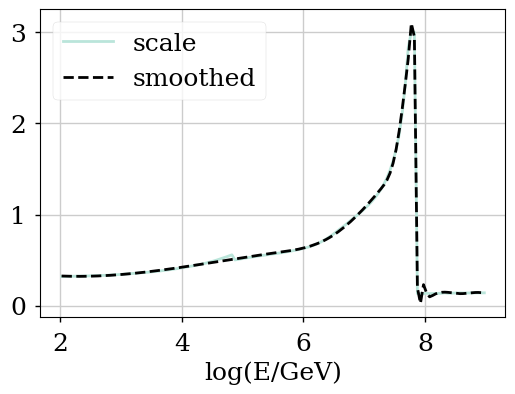

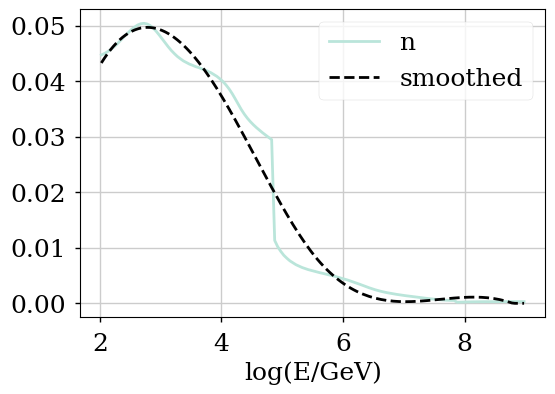

In [8]:
smoothed_fit_params = np.load(join(LOCALPATH, "Eres_fits_smoothed.npy"))

for n in fit_params.dtype.names:
    plt.figure(figsize=(6, 4))
    p = plt.plot(eres_up_mh.bin_mids[0], fit_params[n], label=n)
    p = plt.plot(
        eres_up_mh.bin_mids[0],
        smoothed_fit_params[n],
        label="smoothed",
        color="k",
        ls="--",
    )
    plt.xlabel(eres_up_mh.axis_names[0])
    plt.legend()


# Artificial smearing matrices

## Best reproduction

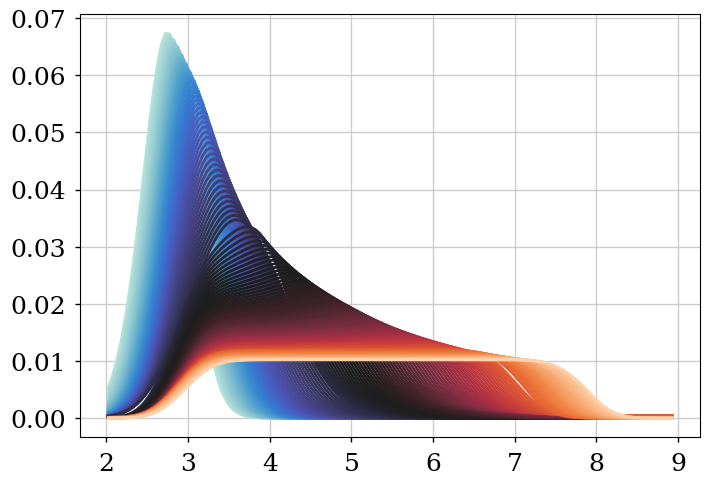

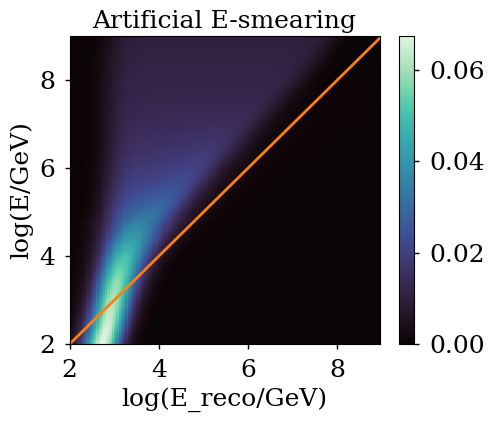

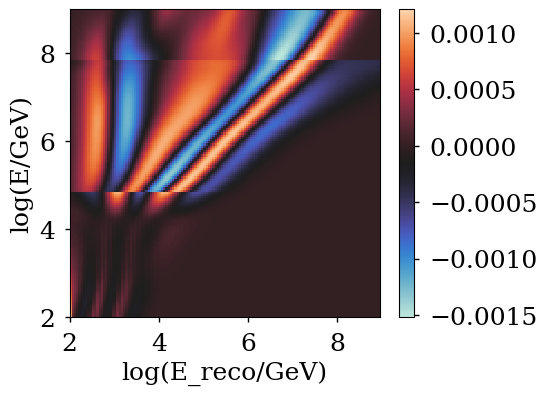

In [9]:
with open(join(LOCALPATH, "artificial_energy_smearing_MH_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
plt.colorbar(plt.gca().get_children()[0])
plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")
plt.colorbar(plt.gca().get_children()[0])

## Smoothed reproduction

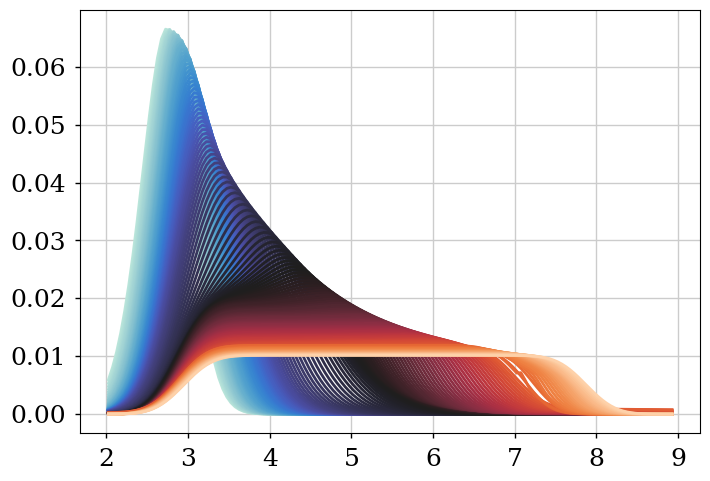

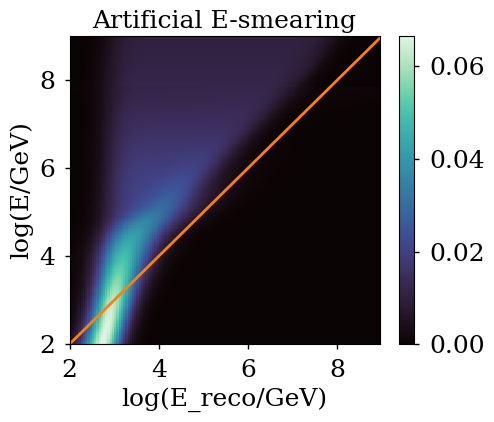

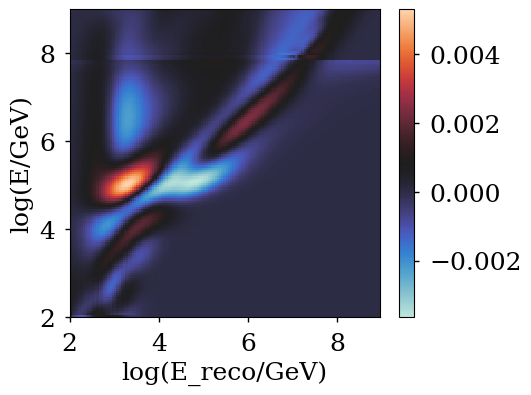

In [10]:
with open(join(LOCALPATH, "artificial_smoothed_energy_smearing_MH_up.pckl"), "rb") as f:
    artificial_2D = pickle.load(f)

_ = plt.plot(artificial_2D.bin_mids[1], artificial_2D.histo.T)

artificial_2D.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
plt.colorbar(plt.gca().get_children()[0])
plt.title("Artificial E-smearing")

(eres_up_mh - artificial_2D).T().plot(cmap="icefire")
plt.colorbar(plt.gca().get_children()[0])

## 1:1 reco reproduction

Text(0.5, 1.0, 'Artificial E-smearing 1:1')

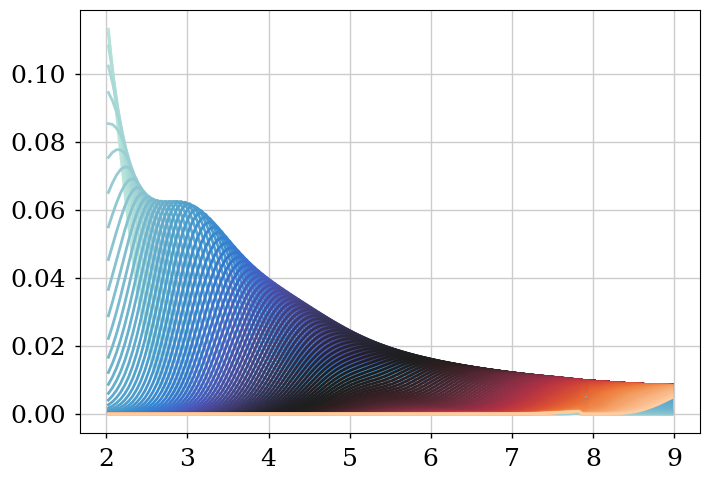

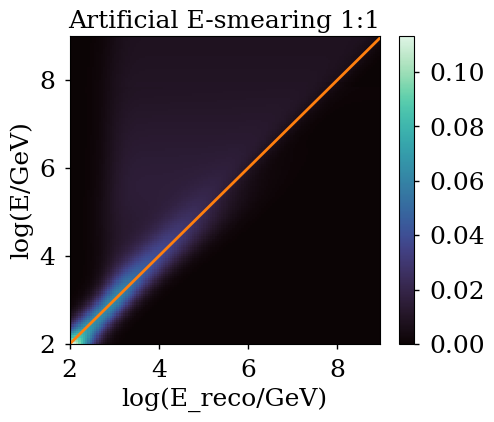

In [11]:
with open(join(LOCALPATH, "idealized_artificial_energy_smearing_MH_up.pckl"), "rb") as f:
    artificial_one2one = pickle.load(f)
_ = plt.plot(artificial_one2one.bin_mids[0], artificial_one2one.histo)
artificial_one2one.T().plot()
plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
plt.colorbar(plt.gca().get_children()[0])
plt.title("Artificial E-smearing 1:1")


## Improved artificial energy smearing

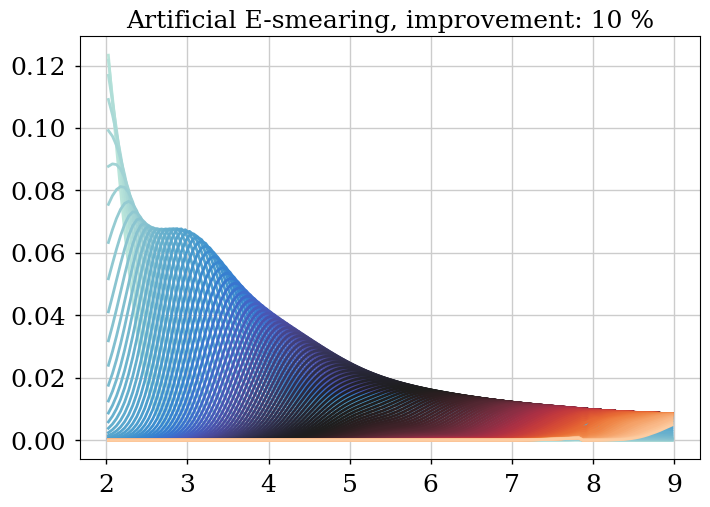

<Figure size 800x550 with 0 Axes>

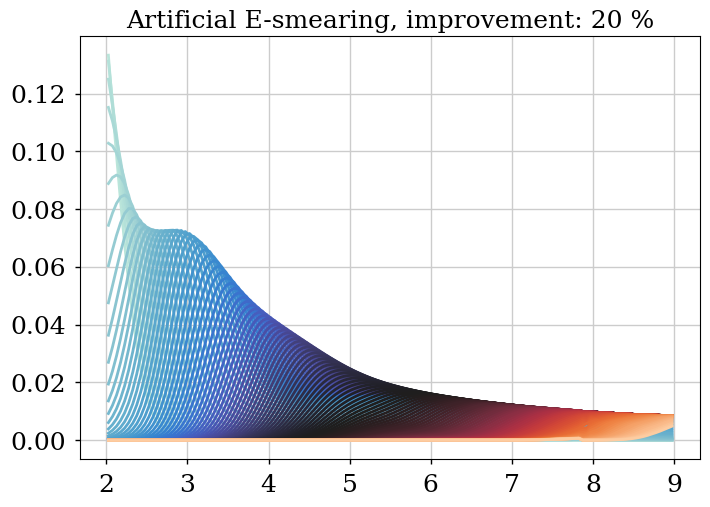

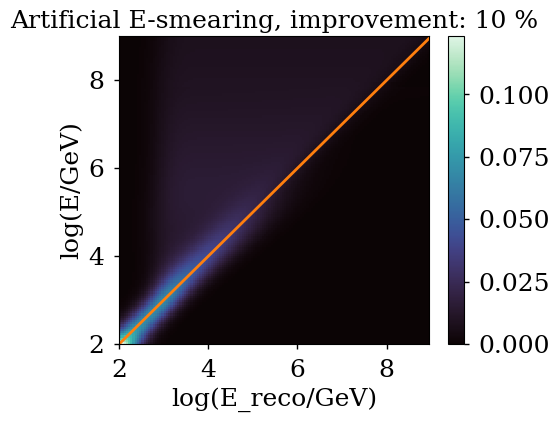

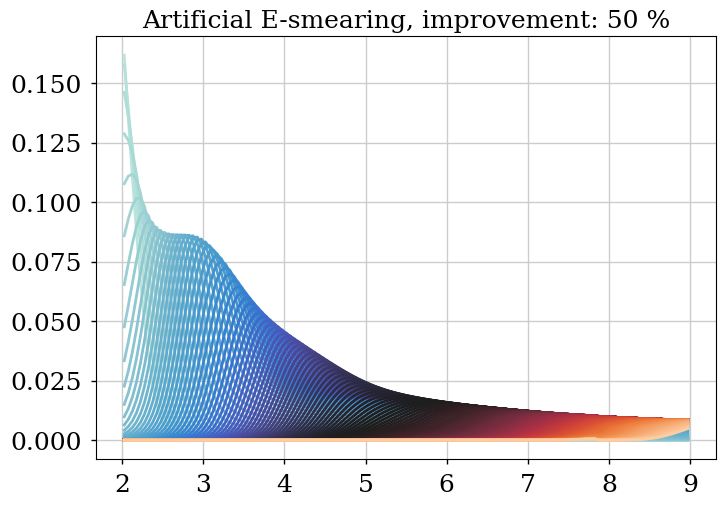

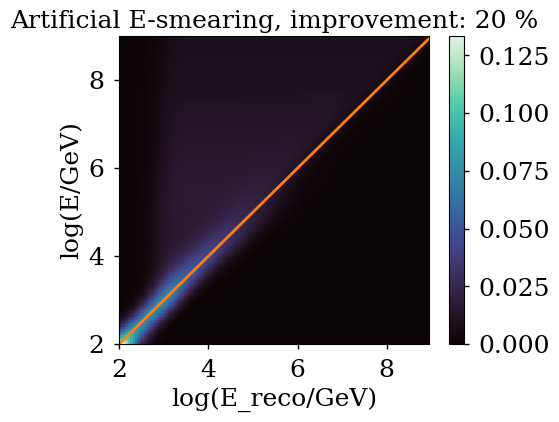

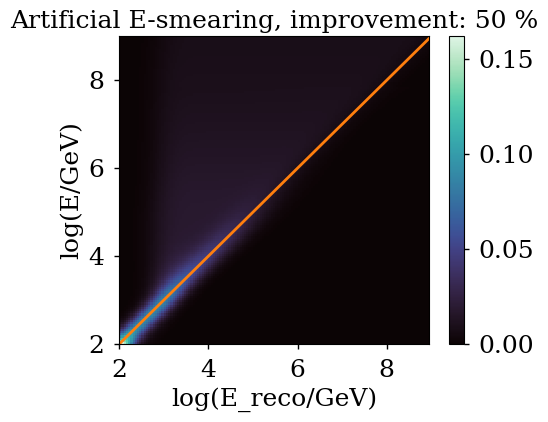

In [12]:
for ii, impro_factor in enumerate([0.1, 0.2, 0.5]):
    filename = join(
        LOCALPATH,
        f"improved_{impro_factor}_artificial_energy_smearing_MH_up.pckl",
    )
    with open(filename, "rb") as f:
        artificial_2D_impro = pickle.load(f)
    plt.figure(ii)
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")
    _ = plt.plot(artificial_2D_impro.bin_mids[0], artificial_2D_impro.histo)

    plt.figure(ii + 20)
    artificial_2D_impro.T().plot()
    plt.plot([E_MIN, E_MAX], [E_MIN, E_MAX], color="tab:orange")
    plt.colorbar(plt.gca().get_children()[0])
    plt.title(f"Artificial E-smearing, improvement: {impro_factor*100:1.0f} %")


# UHE energy smearing
-- not yet updated -- see ../sandbox/energy_resolution_test.ipynb